## Imports

In [1]:
import sys
from pathlib import Path

# Add repo root and code/ to sys.path
repo_root = Path.cwd().parents[1]
sys.path.insert(0, str(repo_root))
sys.path.insert(0, str(repo_root / "code"))

In [11]:
import os
import cv2

import matplotlib.pyplot as plt
import importlib
import pandas as pd
import numpy as np

from utils import helper_functions as hf
from utils import standardization as stdz
from utils.helper_functions import get_or_create_roi_mask

---
### load subjects and plot raw fUS activity of their first session over time with label shading (blue = baseline)

Subject: secundo
  data_directory: C:\Users\ESPCI\Documents\GitHub\fUSPredict\sourcedata\secundo
  data_output_dir: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo
  - MISMATCH: Images=7500, Labels=8109. Shaving to 7500 frames.


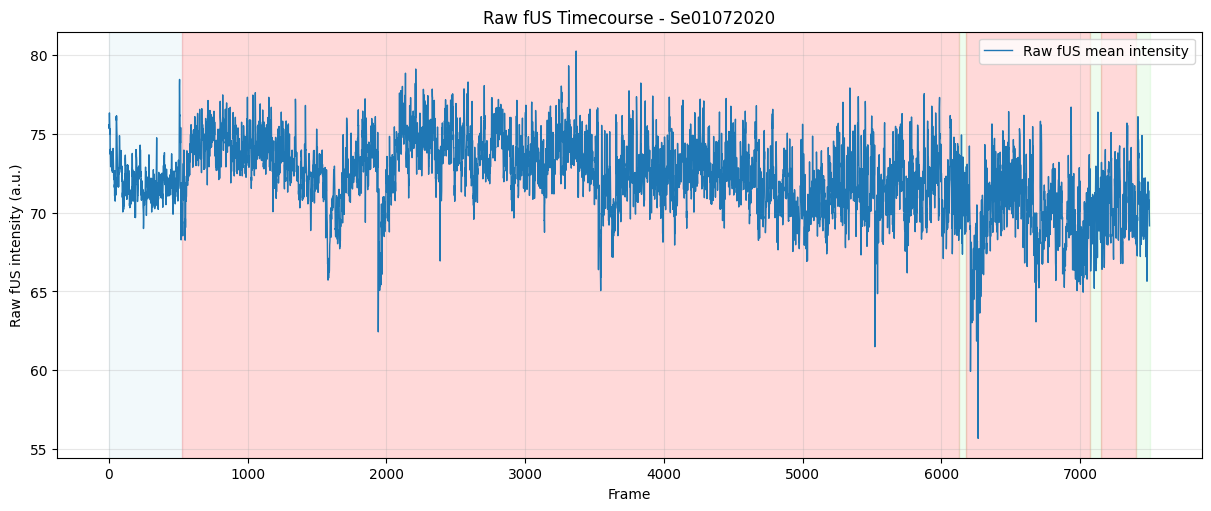

Subject: gus
  data_directory: C:\Users\ESPCI\Documents\GitHub\fUSPredict\sourcedata\gus
  data_output_dir: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus
  - MISMATCH: Images=8000, Labels=9198. Shaving to 8000 frames.


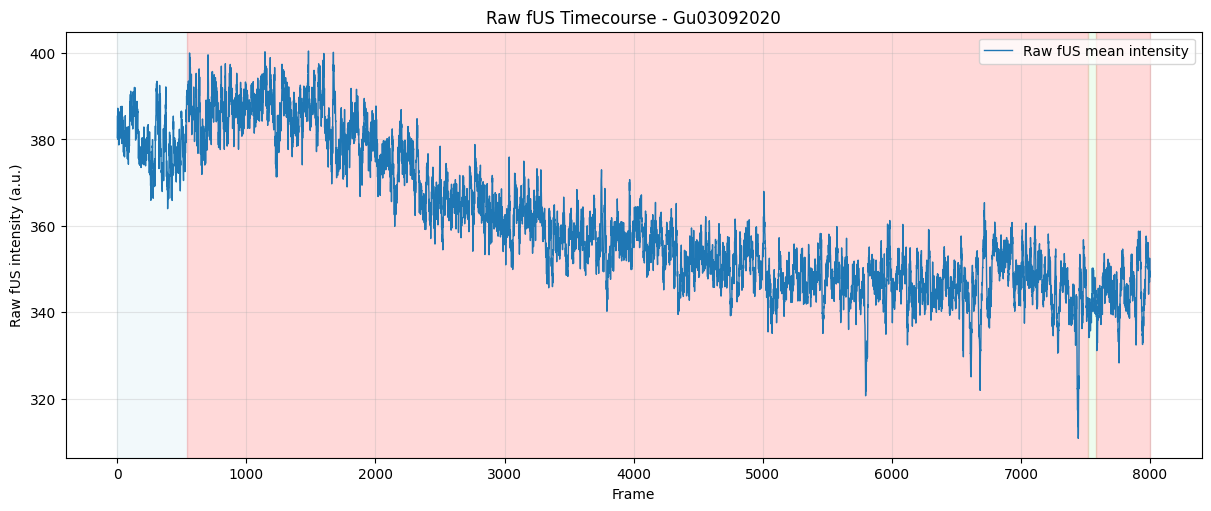

In [3]:
hf = importlib.reload(hf)

subjects = ["secundo", "gus"]

repo_root = Path(r"C:\Users\ESPCI\Documents\GitHub\fUSPredict")
source_root = repo_root / "sourcedata"
deriv_root = repo_root / "derivatives" / "preprocessing"

for subject in subjects:
    data_directory = source_root / subject
    data_output_dir = deriv_root / subject  # subject-specific output folder
    data_output_dir.mkdir(parents=True, exist_ok=True)

    print(f"Subject: {subject}")
    print(f"  data_directory: {data_directory}")
    print(f"  data_output_dir: {data_output_dir}")

    hf.plot_fus_timecourse_with_labels(str(data_directory), sessions="first")

---
### Extract and Save Baseline Frames

Extract baseline frames (blue shading above, label == -1) from all sessions and save as per-session .npz files.

In [4]:
for subject in subjects:
    data_directory = source_root / subject
    data_output_dir = deriv_root / subject
    roi_output_dir = data_output_dir / "roi_masks"
    baseline_output_dir = data_output_dir / "baseline_only"

    data_output_dir.mkdir(parents=True, exist_ok=True)
    roi_output_dir.mkdir(parents=True, exist_ok=True)

    print(f"Input dir: {data_directory}")
    print(f"Baseline output directory: {baseline_output_dir}")

    # Guard against stale path variables from previous cells/runs.
    if subject not in str(baseline_output_dir):
        raise RuntimeError(
            f"Path mismatch: subject={subject} but baseline_output_dir={baseline_output_dir}"
        )

    baseline_files = hf.process_all_baseline_files(
        str(data_directory), str(baseline_output_dir)
    )
    print(f"Saved baseline files: {len(baseline_files)}")



Input dir: C:\Users\ESPCI\Documents\GitHub\fUSPredict\sourcedata\secundo
Baseline output directory: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\baseline_only
Found 34 fUS files to process

⏭️  Skipping Se01072020 (already exists)
⏭️  Skipping Se01092020 (already exists)
⏭️  Skipping Se01102020 (already exists)
⏭️  Skipping Se01122020 (already exists)
⏭️  Skipping Se02122020 (already exists)
⏭️  Skipping Se03022020 (already exists)
⏭️  Skipping Se03092020 (already exists)
⏭️  Skipping Se04022020 (already exists)
⏭️  Skipping Se04032020 (already exists)
⏭️  Skipping Se04062021 (already exists)
⏭️  Skipping Se04082020 (already exists)
⏭️  Skipping Se04092020 (already exists)
⏭️  Skipping Se05022020 (already exists)
⏭️  Skipping Se05082020 (already exists)
⏭️  Skipping Se06012020 (already exists)
⏭️  Skipping Se22092020 (already exists)
⏭️  Skipping Se22102019 (already exists)
⏭️  Skipping Se22112019 (already exists)
⏭️  Skipping Se23072020 (already exists)

---
### Load Baseline Data

Load baseline sessions for model training.

In [5]:
for subject in subjects:
    data_output_dir = deriv_root / subject 
    data_output_dir.mkdir(parents=True, exist_ok=True)
    baseline_output_dir = os.path.join(data_output_dir, "baseline_only")
    # Load all baseline sessions
    baseline_sessions = hf.load_all_baseline(baseline_output_dir)

    # Print summary
    if len(baseline_sessions) > 0:
        print("\nBaseline Data Summary:")
        print(f"  Total sessions: {len(baseline_sessions)}")
        total_frames = sum(s["frames"].shape[0] for s in baseline_sessions)
        print(f"  Total baseline frames: {total_frames:,}")

        spatial_shapes = [s["frames"].shape[1:] for s in baseline_sessions]
        unique_shapes = set(spatial_shapes)
        print(f"  Spatial dimensions: {unique_shapes}")

        # Show frame count distribution
        frame_counts = [s["frames"].shape[0] for s in baseline_sessions]
        print(
            f"  Frames per session: min={min(frame_counts)}, max={max(frame_counts)}, "
            f"mean={np.mean(frame_counts):.0f}, std={np.std(frame_counts):.0f}"
        )

        # first session
        if len(baseline_sessions) > 0:
            first_session = baseline_sessions[0]
            print(f"\n  First session ({first_session['session_id']}):")
            print(f"    Frames: {first_session['frames'].shape[0]}")
            print(f"    Shape: {first_session['frames'].shape}")
            print(f"    Dtype: {first_session['frames'].dtype}")
            print(
                f"    Value range: [{first_session['frames'].min():.2f}, {first_session['frames'].max():.2f}]"
            )

Loaded 34 baseline sessions

Baseline Data Summary:
  Total sessions: 34
  Total baseline frames: 14,043
  Spatial dimensions: {(107, 128), (132, 128), (101, 128), (112, 128), (96, 128), (91, 128), (122, 128)}
  Frames per session: min=1, max=906, mean=413, std=202

  First session (Se01072020):
    Frames: 526
    Shape: (526, 101, 128)
    Dtype: float32
    Value range: [9.31, 3374.84]
Loaded 13 baseline sessions

Baseline Data Summary:
  Total sessions: 13
  Total baseline frames: 5,838
  Spatial dimensions: {(132, 128), (101, 128), (112, 128), (96, 128), (81, 128), (122, 128)}
  Frames per session: min=258, max=549, mean=449, std=123

  First session (Gu03092020):
    Frames: 539
    Shape: (539, 112, 128)
    Dtype: float32
    Value range: [9.11, 16195.08]


---

## Reorient Frames

In [6]:
stdz_modes = ["mean_divide", "zscore"]
# create roi or not
roi_mode = False

# Orientation settings (applied to raw baseline frames before standardization; keep native size for EDA)
ROTATE_K = -1  # np.rot90(..., k=-1) = 90 deg clockwise
RESIZE_BEFORE_REORIENT = False
REORIENT_TARGET_SIZE = int(globals().get("TARGET_SIZE", 112))
SHOW_FIRST_FRAME_BEFORE_AFTER = True

# Safety: avoid double reorientation on reruns.
SKIP_ALREADY_REORIENTED = True
FORCE_REORIENT = False  # set True only if you intentionally want to reapply orientation

# Sessions that need left-right flip after rotation
FLIP_SESSION_IDS_BY_SUBJECT = {
    "secundo": [
        "Se04092020",
        "Se01092020",
        "Se25082020",
        "Se03092020",
        "Se27082020",
        "Se04062020",
        "Se04082020",
        "Se24022020",
    ],
    "gus": ["Gu05082020", "Gu30032021", "Gu30042021"],
}

print("Orientation config:")
print(f"  ROTATE_K={ROTATE_K}")
print(
    f"  RESIZE_BEFORE_REORIENT={RESIZE_BEFORE_REORIENT} | REORIENT_TARGET_SIZE={REORIENT_TARGET_SIZE}"
)
print(
    f"  SKIP_ALREADY_REORIENTED={SKIP_ALREADY_REORIENTED} | FORCE_REORIENT={FORCE_REORIENT}"
)
for subject in subjects:
    ids = FLIP_SESSION_IDS_BY_SUBJECT.get(str(subject), [])
    print(f"  - {subject}: flips={len(ids)}")




Orientation config:
  ROTATE_K=-1
  RESIZE_BEFORE_REORIENT=False | REORIENT_TARGET_SIZE=112
  SKIP_ALREADY_REORIENTED=True | FORCE_REORIENT=False
  - secundo: flips=8
  - gus: flips=3


In [7]:
for subject in subjects:
    data_output_dir = deriv_root / subject
    data_output_dir.mkdir(parents=True, exist_ok=True)
    baseline_output_dir = data_output_dir / "baseline_only"
    preview_dir = data_output_dir / "reorientation_previews"
    preview_dir.mkdir(parents=True, exist_ok=True)

    baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

    if len(baseline_sessions) == 0:
        print(f"No baseline sessions for {subject}")
        continue

    print(f"\nSubject: {subject} | reorientation step")
    print(f"  Sessions: {len(baseline_sessions)}")

    def _as_bool_scalar(v):
        try:
            arr = np.asarray(v)
            if arr.size == 0:
                return False
            return bool(arr.squeeze())
        except Exception:
            return bool(v)

    def _save_before_after_first_frame(before_frame, after_frame, subject, session_id):
        def _prep(img):
            arr = np.asarray(img, dtype=np.float32)
            finite = np.isfinite(arr)
            if not np.any(finite):
                return np.zeros_like(arr, dtype=np.float32)
            lo, hi = np.percentile(arr[finite], [1.0, 99.0])
            if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
                lo = float(np.nanmin(arr[finite]))
                hi = float(np.nanmax(arr[finite]))
            scaled = (arr - lo) / (hi - lo + 1e-8)
            return np.clip(scaled, 0.0, 1.0)

        fig, axes = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)
        axes[0].imshow(_prep(before_frame), cmap="gray")
        axes[0].set_title("Before")
        axes[0].axis("off")
        axes[1].imshow(_prep(after_frame), cmap="gray")
        axes[1].set_title("After")
        axes[1].axis("off")
        fig.suptitle(f"{subject} | {session_id} | first baseline frame")

        out_path = preview_dir / f"{subject}_{session_id}_before_after.png"
        fig.savefig(out_path, dpi=180, bbox_inches="tight")
        plt.close(fig)
        print(f"  [preview] saved {out_path.name}")

    flip_ids = set(FLIP_SESSION_IDS_BY_SUBJECT.get(str(subject), []))
    n_saved = 0
    n_skipped_already = 0

    for sess in baseline_sessions:
        session_id = str(sess["session_id"])
        metadata_in = dict(sess.get("metadata", {}))
        already_reoriented = _as_bool_scalar(metadata_in.get("reoriented", False))

        frames_in = np.asarray(sess["frames"], dtype=np.float32)
        if frames_in.ndim != 3:
            raise ValueError(
                f"Expected baseline frames [T,H,W], got {frames_in.shape} for {subject}/{session_id}"
            )

        frames_work = frames_in
        if RESIZE_BEFORE_REORIENT:
            frames_work = hf.np_pad_or_crop_to_square(
                frames_work,
                target_size=REORIENT_TARGET_SIZE,
                verbose=False,
            )
            frames_work = hf.squeeze_frames(frames_work)

        before_first = np.asarray(frames_work[0], dtype=np.float32)

        frames_out = np.rot90(frames_work, k=int(ROTATE_K), axes=(1, 2))
        did_flip = session_id in flip_ids
        if did_flip:
            frames_out = np.flip(frames_out, axis=2)

        after_first = np.asarray(frames_out[0], dtype=np.float32)

        if SHOW_FIRST_FRAME_BEFORE_AFTER:
            _save_before_after_first_frame(
                before_first,
                after_first,
                subject=subject,
                session_id=session_id,
            )

        if already_reoriented and SKIP_ALREADY_REORIENTED and not FORCE_REORIENT:
            n_skipped_already += 1
            print(f"  [raw] skip {session_id}: already reoriented")
            continue

        metadata = dict(metadata_in)
        metadata["spatial_shape"] = np.array(frames_out.shape[1:], dtype=np.int64)
        metadata["n_baseline_frames"] = int(frames_out.shape[0])
        metadata["dtype"] = str(frames_out.dtype)
        metadata["reoriented"] = np.array(True)
        metadata["rotate_k"] = np.array(int(ROTATE_K), dtype=np.int64)
        metadata["flip_lr_applied"] = np.array(bool(did_flip))

        raw_out_path = baseline_output_dir / f"baseline_{session_id}.npz"
        save_kwargs = {
            "frames": frames_out.astype(np.float32, copy=False),
            "session_id": session_id,
            **metadata,
        }
        original_indices = sess.get("original_indices", None)
        if original_indices is not None:
            save_kwargs["original_indices"] = np.asarray(original_indices)

        np.savez_compressed(raw_out_path, **save_kwargs)
        n_saved += 1

        print(
            f"  [raw] saved {raw_out_path.name} | shape {frames_in.shape} -> {frames_out.shape} | flip={did_flip}"
        )

    print(
        f"  -> reorientation done: saved {n_saved}/{len(baseline_sessions)} sessions | "
        f"skipped_already_reoriented={n_skipped_already}"
    )


Loaded 34 baseline sessions

Subject: secundo | reorientation step
  Sessions: 34
  [preview] saved secundo_Se01072020_before_after.png
  [raw] skip Se01072020: already reoriented
  [preview] saved secundo_Se01092020_before_after.png
  [raw] skip Se01092020: already reoriented
  [preview] saved secundo_Se01102020_before_after.png
  [raw] skip Se01102020: already reoriented
  [preview] saved secundo_Se01122020_before_after.png
  [raw] skip Se01122020: already reoriented
  [preview] saved secundo_Se02122020_before_after.png
  [raw] skip Se02122020: already reoriented
  [preview] saved secundo_Se03022020_before_after.png
  [raw] skip Se03022020: already reoriented
  [preview] saved secundo_Se03092020_before_after.png
  [raw] skip Se03092020: already reoriented
  [preview] saved secundo_Se04022020_before_after.png
  [raw] skip Se04022020: already reoriented
  [preview] saved secundo_Se04032020_before_after.png
  [raw] skip Se04032020: already reoriented
  [preview] saved secundo_Se04062021

---
## stdzalize Frames 

In [8]:
for subject in subjects:
    data_output_dir = deriv_root / subject
    data_output_dir.mkdir(parents=True, exist_ok=True)
    roi_output_dir = data_output_dir / "roi_masks"
    roi_output_dir.mkdir(parents=True, exist_ok=True)
    baseline_output_dir = data_output_dir / "baseline_only"

    # Load raw baseline sessions (expects reorientation cell already run).
    baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

    if len(baseline_sessions) == 0:
        print(f"No baseline sessions for {subject}")
        continue

    standardized_root = data_output_dir / "baseline_only_standardized"
    standardized_root.mkdir(parents=True, exist_ok=True)

    print(f"\nSubject: {subject} | standardization step")
    print(f"  Sessions: {len(baseline_sessions)}")

    def choose_representative_session(sessions, strategy="most_stable"):
        if strategy == "random":
            rng = np.random.default_rng(42)
            return sessions[int(rng.integers(0, len(sessions)))]
        if strategy != "most_stable":
            raise ValueError(f"Unknown strategy: {strategy}")

        def _stability_score(sess):
            frames = np.asarray(sess["frames"], dtype=np.float32)
            if frames.shape[0] < 2:
                return np.inf
            return float(np.median(np.abs(np.diff(frames, axis=0))))

        return min(sessions, key=_stability_score)

    if roi_mode == True:

        def _load_or_create_roi_mask_npz(frames, subject, session_id, roi_output_dir):
            roi_stem = f"roi_{subject}_{session_id}"
            roi_npz_path = roi_output_dir / f"{roi_stem}.npz"

            if roi_npz_path.exists():
                with np.load(roi_npz_path, allow_pickle=False) as data:
                    if "mask" not in data.files:
                        raise KeyError(f"'mask' missing in {roi_npz_path}")
                    return data["mask"].astype(bool)

            cwd_prev = os.getcwd()
            try:
                os.chdir(roi_output_dir)
                mask = get_or_create_roi_mask(
                    frames, f"{subject}_{session_id}", force_auto=True
                )
            finally:
                os.chdir(cwd_prev)

            mask = np.asarray(mask, dtype=bool)
            np.savez_compressed(
                roi_npz_path,
                mask=mask,
                subject=subject,
                session_id=session_id,
            )

            legacy_npy = roi_output_dir / f"{roi_stem}.npy"
            if legacy_npy.exists():
                legacy_npy.unlink()

            return mask

        roi_by_session = {}
        for sess in baseline_sessions:
            session_id = sess["session_id"]
            frames = sess["frames"]
            roi_by_session[session_id] = _load_or_create_roi_mask_npz(
                frames,
                subject,
                session_id,
                roi_output_dir,
            )

        for mode in stdz_modes:
            mode_dir = standardized_root / mode
            mode_dir.mkdir(parents=True, exist_ok=True)
            n_saved = 0

            for sess in baseline_sessions:
                frames = sess["frames"]
                session_id = sess["session_id"]
                roi = roi_by_session[session_id]

                stdz_frames = stdz.standardize_frames_pixelwise(
                    frames, method=mode, clip_abs=None, roi_mask=roi
                )

                out_path = mode_dir / f"baseline_{session_id}_{mode}.npz"
                np.savez_compressed(
                    out_path,
                    frames=stdz_frames,
                    session_id=session_id,
                    standardization=mode,
                    source="raw_baseline_only_reoriented",
                )
                n_saved += 1
                print(f"  [stdz:{mode}] saved {out_path.name}")

            sample_session = choose_representative_session(
                baseline_sessions, strategy="most_stable"
            )
            sample_roi = roi_by_session[sample_session["session_id"]]
            sample = stdz.standardize_frames_pixelwise(
                sample_session["frames"], method=mode, roi_mask=sample_roi
            )
            print(
                f"  -> {mode}: saved {n_saved}/{len(baseline_sessions)} sessions | "
                f"sample range=[{sample.min():.4f}, {sample.max():.4f}]"
            )
    else:
        for mode in stdz_modes:
            mode_dir = standardized_root / mode
            mode_dir.mkdir(parents=True, exist_ok=True)
            n_saved = 0

            for sess in baseline_sessions:
                frames = sess["frames"]
                session_id = sess["session_id"]

                stdz_frames = stdz.standardize_frames_pixelwise(
                    frames, method=mode, clip_abs=None
                )

                out_path = mode_dir / f"baseline_{session_id}_{mode}.npz"
                np.savez_compressed(
                    out_path,
                    frames=stdz_frames,
                    session_id=session_id,
                    standardization=mode,
                    source="raw_baseline_only_reoriented",
                )
                n_saved += 1
                print(f"  [stdz:{mode}] saved {out_path.name}")

            sample_session = choose_representative_session(
                baseline_sessions, strategy="most_stable"
            )
            sample = stdz.standardize_frames_pixelwise(
                sample_session["frames"], method=mode
            )
            print(
                f"  -> {mode}: saved {n_saved}/{len(baseline_sessions)} sessions | "
                f"sample range=[{sample.min():.4f}, {sample.max():.4f}]"
            )



Loaded 34 baseline sessions

Subject: secundo | standardization step
  Sessions: 34
  [stdz:mean_divide] saved baseline_Se01072020_mean_divide.npz
  [stdz:mean_divide] saved baseline_Se01092020_mean_divide.npz
  [stdz:mean_divide] saved baseline_Se01102020_mean_divide.npz
  [stdz:mean_divide] saved baseline_Se01122020_mean_divide.npz
  [stdz:mean_divide] saved baseline_Se02122020_mean_divide.npz
  [stdz:mean_divide] saved baseline_Se03022020_mean_divide.npz
  [stdz:mean_divide] saved baseline_Se03092020_mean_divide.npz
  [stdz:mean_divide] saved baseline_Se04022020_mean_divide.npz
  [stdz:mean_divide] saved baseline_Se04032020_mean_divide.npz
  [stdz:mean_divide] saved baseline_Se04062021_mean_divide.npz
  [stdz:mean_divide] saved baseline_Se04082020_mean_divide.npz
  [stdz:mean_divide] saved baseline_Se04092020_mean_divide.npz
  [stdz:mean_divide] saved baseline_Se05022020_mean_divide.npz
  [stdz:mean_divide] saved baseline_Se05082020_mean_divide.npz
  [stdz:mean_divide] saved baselin

---
## save triplet video of raw + 2 standardized modes

In [12]:
fallback_original_fps = 10

%matplotlib widget


# display tuning (visualization only)
mean_mask_percentile = 45.0  # keep brighter structural pixels
std_mask_percentile = 45.0  # keep pixels with meaningful temporal variation
signed_clip_percentile = 97.0  # tighter clipping than 99 to reduce speckle dominance
gaussian_blur_ksize = 3  # 0/1 disables blur
header_h = 28  # top strip for labels


def _to_float_scalar(value):
    if value is None:
        return None
    arr = np.asarray(value)
    if arr.size == 0:
        return None
    try:
        return float(arr.squeeze())
    except Exception:
        return None


def get_session_fps(sample_session, default_fps=fallback_original_fps):
    """Read original acquisition FPS from session metadata when available."""
    metadata = sample_session.get("metadata", {})
    fps_keys = [
        "source_fps",
        "fps",
        "frame_rate",
        "framerate",
        "sampling_rate",
        "acq_fps",
    ]
    for key in fps_keys:
        if key in metadata:
            fps_val = _to_float_scalar(metadata[key])
            if fps_val is not None and fps_val > 0:
                return fps_val
    return float(default_fps)


def scale_raw_to_u8(frames, q_low=1.0, q_high=99.0):
    """Positive-intensity visualization for raw frames."""
    lo = np.percentile(frames, q_low)
    hi = np.percentile(frames, q_high)
    if hi <= lo:
        lo = float(frames.min())
        hi = float(frames.max())
    scaled = (frames - lo) / (hi - lo + 1e-8)
    return np.clip(scaled * 255.0, 0, 255).astype(np.uint8), lo, hi


def scale_signed_to_u8(frames, abs_percentile=97.0):
    """
    Signed visualization for standardized frames.
    127 ~= zero, darker negative, brighter positive.
    """
    a = np.percentile(np.abs(frames), abs_percentile)
    if a <= 1e-8:
        a = 1.0
    clipped = np.clip(frames, -a, a)
    scaled = ((clipped / a) + 1.0) * 127.5
    return np.clip(scaled, 0, 255).astype(np.uint8), a


def apply_optional_blur(gray_u8, ksize=3):
    if ksize is None or ksize <= 1:
        return gray_u8
    return cv2.GaussianBlur(gray_u8, (ksize, ksize), 0)


def add_header(panel_gray, text, header_height=28):
    panel_bgr = cv2.cvtColor(panel_gray, cv2.COLOR_GRAY2BGR)
    h, w = panel_bgr.shape[:2]
    out = np.zeros((h + header_height, w, 3), dtype=np.uint8)
    out[:header_height] = (0, 0, 0)
    out[header_height:] = panel_bgr
    cv2.putText(
        out,
        text,
        (8, int(header_height * 0.72)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 0),
        1,
        cv2.LINE_AA,
    )
    return out


def choose_representative_session(sessions, strategy="most_stable"):
    if strategy == "random":
        rng = np.random.default_rng(42)
        return sessions[int(rng.integers(0, len(sessions)))]
    if strategy != "most_stable":
        raise ValueError(f"Unknown strategy: {strategy}")

    def _stability_score(sess):
        frames = np.asarray(sess["frames"], dtype=np.float32)
        if frames.shape[0] < 2:
            return np.inf
        # Lower median frame-to-frame absolute difference = more stable baseline exemplar.
        return float(np.median(np.abs(np.diff(frames, axis=0))))

    return min(sessions, key=_stability_score)


for subject in subjects:
    data_output_dir = deriv_root / subject
    data_output_dir.mkdir(parents=True, exist_ok=True)
    baseline_output_dir = data_output_dir / "baseline_only"

    baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))

    if len(baseline_sessions) == 0:
        print(f"No baseline sessions for {subject}")
        continue

    # sample acquisition: most stable baseline session
    sample_session = choose_representative_session(
        baseline_sessions, strategy="most_stable"
    )
    sample_frames_raw = sample_session["frames"].astype(np.float32, copy=False)

    # load precomputed standardized baseline frames from previous cell outputs
    standardized_root = data_output_dir / "baseline_only_standardized"
    sample_session_id = sample_session["session_id"]
    sample_mean_path = (
        standardized_root
        / "mean_divide"
        / f"baseline_{sample_session_id}_mean_divide.npz"
    )
    sample_z_path = (
        standardized_root / "zscore" / f"baseline_{sample_session_id}_zscore.npz"
    )

    if not sample_mean_path.exists() or not sample_z_path.exists():
        raise FileNotFoundError(
            f"Missing precomputed standardized files for {subject}, session={sample_session_id}. "
            f"Expected: {sample_mean_path} and {sample_z_path}. Run the standardization cell first."
        )

    sample_frames_mean = np.load(sample_mean_path)["frames"].astype(
        np.float32, copy=False
    )
    sample_frames_z = np.load(sample_z_path)["frames"].astype(np.float32, copy=False)

    # sanity checks (standardization math)
    mean_map_raw = sample_frames_raw.mean(axis=0)
    std_map_raw = sample_frames_raw.std(axis=0)

    valid_mean = np.abs(mean_map_raw) > 1e-8
    valid_std = std_map_raw > 1e-8

    md_mean_abs_err = (
        float(np.mean(np.abs(sample_frames_mean.mean(axis=0)[valid_mean])))
        if np.any(valid_mean)
        else np.nan
    )
    zs_mean_abs_err = (
        float(np.mean(np.abs(sample_frames_z.mean(axis=0)[valid_std])))
        if np.any(valid_std)
        else np.nan
    )
    zs_std_abs_err = (
        float(np.mean(np.abs(sample_frames_z.std(axis=0)[valid_std] - 1.0)))
        if np.any(valid_std)
        else np.nan
    )

    print(
        f"{subject} sanity | mean_divide mean abs err={md_mean_abs_err:.6f}, "
        f"zscore mean abs err={zs_mean_abs_err:.6f}, zscore std abs err={zs_std_abs_err:.6f}"
    )

    # display mask to suppress low-signal/background amplification (visualization only)
    mean_thr = np.percentile(mean_map_raw, mean_mask_percentile)
    std_thr = np.percentile(std_map_raw, std_mask_percentile)
    display_mask = (mean_map_raw >= mean_thr) & (std_map_raw >= std_thr)

    mean_display = sample_frames_mean.copy()
    z_display = sample_frames_z.copy()
    mean_display[:, ~display_mask] = 0.0
    z_display[:, ~display_mask] = 0.0

    raw_u8, raw_lo, raw_hi = scale_raw_to_u8(sample_frames_raw)
    mean_u8, mean_abs = scale_signed_to_u8(
        mean_display, abs_percentile=signed_clip_percentile
    )
    z_u8, z_abs = scale_signed_to_u8(z_display, abs_percentile=signed_clip_percentile)

    n_frames = min(raw_u8.shape[0], mean_u8.shape[0], z_u8.shape[0])
    h, w = raw_u8.shape[1], raw_u8.shape[2]
    session_fps = get_session_fps(sample_session)

    triplet_path = data_output_dir / f"{subject}_baseline_triplet_raw_mean_zscore.mp4"
    tmp_triplet_path = triplet_path.with_suffix(".tmp.mp4")
    if tmp_triplet_path.exists():
        tmp_triplet_path.unlink()
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(
        str(tmp_triplet_path), fourcc, session_fps, (w * 3, h + header_h), isColor=True
    )

    if not out.isOpened():
        raise RuntimeError(f"Could not open video writer for {triplet_path}")

    mask_pct = 100.0 * float(display_mask.mean())

    for t in range(n_frames):
        raw_panel = raw_u8[t]
        mean_panel = apply_optional_blur(mean_u8[t], ksize=gaussian_blur_ksize)
        z_panel = apply_optional_blur(z_u8[t], ksize=gaussian_blur_ksize)

        raw_lbl = "raw"
        mean_lbl = "mean_divide +/-"
        z_lbl = "zscore"

        raw_bgr = add_header(raw_panel, raw_lbl, header_height=header_h)
        mean_bgr = add_header(mean_panel, mean_lbl, header_height=header_h)
        z_bgr = add_header(z_panel, z_lbl, header_height=header_h)

        panel = np.concatenate([raw_bgr, mean_bgr, z_bgr], axis=1)
        out.write(panel)

    out.release()
    os.replace(tmp_triplet_path, triplet_path)
    print(
        f"Saved triplet video for {subject} | session={sample_session['session_id']} | "
        f"fps={session_fps:.3f} | frames={n_frames} | display_mask={mask_pct:.1f}% -> {triplet_path}"
    )

Loaded 34 baseline sessions
secundo sanity | mean_divide mean abs err=0.000000, zscore mean abs err=0.000003, zscore std abs err=0.002812
Saved triplet video for secundo | session=Se27082020 | fps=10.000 | frames=544 | display_mask=52.4% -> C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\secundo_baseline_triplet_raw_mean_zscore.mp4
Loaded 13 baseline sessions
gus sanity | mean_divide mean abs err=0.000000, zscore mean abs err=0.000002, zscore std abs err=0.002993
Saved triplet video for gus | session=Gu12042021 | fps=10.000 | frames=268 | display_mask=48.2% -> C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\gus_baseline_triplet_raw_mean_zscore.mp4


Seed location: global constant set location

---
### ACF QC Export
Compute per-session/per-mode baseline signal quality checks and save `acf_qc_summary.csv` per subject.


In [13]:
ACF_QC_MODES = ["raw", "mean_divide", "zscore"]
ACF_QC_VAR_EPS = 1e-12
acf_qc_filename = "acf_qc_summary.csv"


def _qc_baseline_npz_path(deriv_root, subject, session_id, mode):
    if mode == "raw":
        return deriv_root / subject / "baseline_only" / f"baseline_{session_id}.npz"
    return (
        deriv_root
        / subject
        / "baseline_only_standardized"
        / mode
        / f"baseline_{session_id}_{mode}.npz"
    )


def _qc_load_saved_frames(deriv_root, subject, session_id, mode):
    fp = _qc_baseline_npz_path(deriv_root, subject, session_id, mode)
    if not fp.exists():
        raise FileNotFoundError(f"missing file: {fp}")
    with np.load(fp, allow_pickle=False) as data:
        if "frames" not in data.files:
            raise KeyError(f"'frames' missing in {fp}")
        arr = np.asarray(data["frames"], dtype=np.float32)
    if arr.ndim == 4 and arr.shape[1] == 1:
        arr = arr[:, 0, :, :]
    if arr.ndim != 3:
        raise ValueError(f"unexpected frame shape {arr.shape}")
    return arr, fp


def _qc_acf_signal_check(frames_3d, var_eps=1e-12):
    x_raw = np.nanmean(frames_3d, axis=(1, 2)).astype(np.float64)
    finite = np.isfinite(x_raw)
    x = x_raw[finite]

    n_total = int(frames_3d.shape[0])
    n_finite = int(np.sum(finite))
    n_nonfinite = int(np.sum(~finite))

    if x.size < 2:
        return {
            "pass_acf_qc": False,
            "fail_reason": "too_short_or_nan_only",
            "n_signal_samples": int(x.size),
            "n_frames_total": n_total,
            "n_frames_finite_global": n_finite,
            "n_frames_nonfinite_global": n_nonfinite,
            "global_std_centered": np.nan,
            "global_std_raw": float(np.nanstd(x_raw))
            if np.isfinite(np.nanstd(x_raw))
            else np.nan,
            "spatial_finite_fraction": float(np.mean(np.isfinite(frames_3d))),
        }

    xc = x - np.mean(x)
    var = np.var(xc)
    if not np.isfinite(var):
        return {
            "pass_acf_qc": False,
            "fail_reason": "nan_variance",
            "n_signal_samples": int(x.size),
            "n_frames_total": n_total,
            "n_frames_finite_global": n_finite,
            "n_frames_nonfinite_global": n_nonfinite,
            "global_std_centered": np.nan,
            "global_std_raw": float(np.nanstd(x_raw))
            if np.isfinite(np.nanstd(x_raw))
            else np.nan,
            "spatial_finite_fraction": float(np.mean(np.isfinite(frames_3d))),
        }

    if var < var_eps:
        return {
            "pass_acf_qc": False,
            "fail_reason": f"near_constant_var<{var_eps}",
            "n_signal_samples": int(x.size),
            "n_frames_total": n_total,
            "n_frames_finite_global": n_finite,
            "n_frames_nonfinite_global": n_nonfinite,
            "global_std_centered": float(np.sqrt(var)),
            "global_std_raw": float(np.nanstd(x_raw))
            if np.isfinite(np.nanstd(x_raw))
            else np.nan,
            "spatial_finite_fraction": float(np.mean(np.isfinite(frames_3d))),
        }

    return {
        "pass_acf_qc": True,
        "fail_reason": "",
        "n_signal_samples": int(x.size),
        "n_frames_total": n_total,
        "n_frames_finite_global": n_finite,
        "n_frames_nonfinite_global": n_nonfinite,
        "global_std_centered": float(np.sqrt(var)),
        "global_std_raw": float(np.nanstd(x_raw))
        if np.isfinite(np.nanstd(x_raw))
        else np.nan,
        "spatial_finite_fraction": float(np.mean(np.isfinite(frames_3d))),
    }


for subject in subjects:
    rows = []
    print(f"\n[{subject}] computing ACF QC summary")

    baseline_output_dir = deriv_root / subject / "baseline_only"
    baseline_sessions = hf.load_all_baseline(str(baseline_output_dir))
    if len(baseline_sessions) == 0:
        print(f"  - no baseline sessions for {subject}")
        continue

    for sess in baseline_sessions:
        session_id = str(sess["session_id"])
        for mode in ACF_QC_MODES:
            try:
                arr, fp = _qc_load_saved_frames(deriv_root, subject, session_id, mode)
                qc = _qc_acf_signal_check(arr, var_eps=ACF_QC_VAR_EPS)
                rows.append(
                    {
                        "subject": subject,
                        "session_id": session_id,
                        "mode": mode,
                        "source_file": str(fp),
                        **qc,
                    }
                )
            except Exception as e:
                rows.append(
                    {
                        "subject": subject,
                        "session_id": session_id,
                        "mode": mode,
                        "source_file": str(
                            _qc_baseline_npz_path(deriv_root, subject, session_id, mode)
                        ),
                        "pass_acf_qc": False,
                        "fail_reason": f"load_error: {e}",
                        "n_signal_samples": 0,
                        "n_frames_total": np.nan,
                        "n_frames_finite_global": np.nan,
                        "n_frames_nonfinite_global": np.nan,
                        "global_std_centered": np.nan,
                        "global_std_raw": np.nan,
                        "spatial_finite_fraction": np.nan,
                    }
                )

    out_path = deriv_root / subject / acf_qc_filename
    df = pd.DataFrame(rows)
    df.to_csv(out_path, index=False)

    n_total = int(df.shape[0])
    n_pass = int(df["pass_acf_qc"].fillna(False).sum())
    n_fail = n_total - n_pass
    print(f"  - saved {out_path}")
    print(f"  - entries={n_total} | pass={n_pass} | fail={n_fail}")


[secundo] computing ACF QC summary
Loaded 34 baseline sessions
  - saved C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\acf_qc_summary.csv
  - entries=102 | pass=96 | fail=6

[gus] computing ACF QC summary
Loaded 13 baseline sessions
  - saved C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\gus\acf_qc_summary.csv
  - entries=39 | pass=39 | fail=0
